<a href="https://colab.research.google.com/github/Lasitha-Jayawardana/IDS/blob/main/K_Mean_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import math
from sklearn.cluster import KMeans
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Raw Data into Python

In [ ]:
# Loading the data
test_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/Colab Notebooks/IDS/NSL_Train.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/Colab Notebooks/IDS/NSL_Test.csv')

# print the shape
print(train_data.shape)
print(test_data.shape)


#runs the first 5 rows
train_data.head()

(22544, 43)
(125973, 43)


,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,2,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,3,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,4,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,5,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [ ]:
test_data.head()

,id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,1,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,2,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,3,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,4,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,5,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
test_data.info()
#test_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           125973 non-null  int64  
 1   duration                     125973 non-null  int64  
 2   protocol_type                125973 non-null  object 
 3   service                      125973 non-null  object 
 4   flag                         125973 non-null  object 
 5   src_bytes                    125973 non-null  int64  
 6   dst_bytes                    125973 non-null  int64  
 7   land                         125973 non-null  int64  
 8   wrong_fragment               125973 non-null  int64  
 9   urgent                       125973 non-null  int64  
 10  hot                          125973 non-null  int64  
 11  num_failed_logins            125973 non-null  int64  
 12  logged_in                    125973 non-null  int64  
 13 

In [ ]:
data = pd.concat([train_data, test_data],axis=0,sort=False)
data.duplicated().sum()

0

# Data Preprocessing ¶

In [ ]:
# Checking for null values
data.isnull().sum()

id                             0
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_r

In [ ]:
#convert object data to categorical
data[['protocol_type', 'service', 'flag','class']]= data[['protocol_type', 'service', 'flag','class']].apply(lambda x: x.astype('category'))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148517 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   id                           148517 non-null  int64   
 1   duration                     148517 non-null  int64   
 2   protocol_type                148517 non-null  category
 3   service                      148517 non-null  category
 4   flag                         148517 non-null  category
 5   src_bytes                    148517 non-null  int64   
 6   dst_bytes                    148517 non-null  int64   
 7   land                         148517 non-null  int64   
 8   wrong_fragment               148517 non-null  int64   
 9   urgent                       148517 non-null  int64   
 10  hot                          148517 non-null  int64   
 11  num_failed_logins            148517 non-null  int64   
 12  logged_in                    148517 non-null

In [ ]:
# select categiircal column and count unique values 

for column in data.select_dtypes('category'):
    unique_vals = np.unique(data[column])
    nr_values = len(unique_vals)
    print('{} :{}'.format(column, nr_values))

protocol_type :3
service :70
flag :11
class :2


In [ ]:
print(".....................protocol_type.........................\n")
print(data['protocol_type'].describe())
print("\n\n.....................service.........................\n")
print(data['service'].describe())
print("\n\n......................flag........................\n")
print(data['flag'].describe())


.....................protocol_type.........................
count     148517
unique         3
top          tcp
freq      121569
Name: protocol_type, dtype: object


.....................service.........................
count     148517
unique        70
top         http
freq       48191
Name: service, dtype: object


......................flag........................
count     148517
unique        11
top           SF
freq       89820
Name: flag, dtype: object


In [ ]:
data.columns

Index(['id', 'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

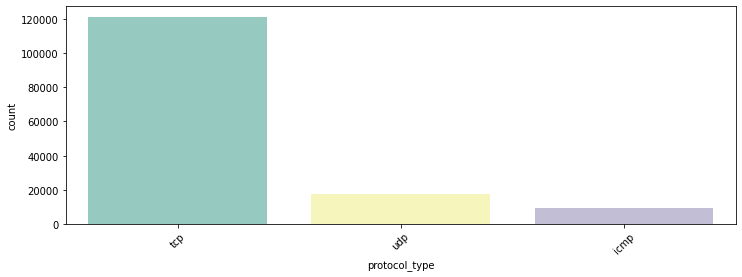

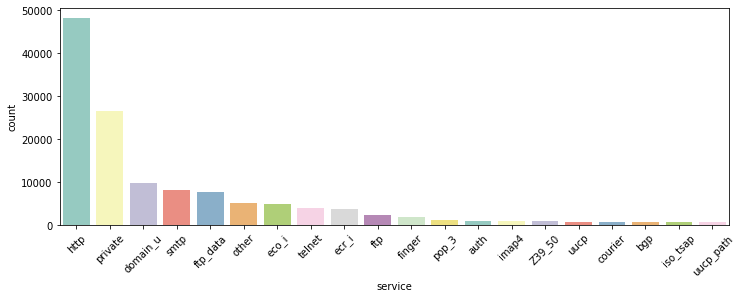

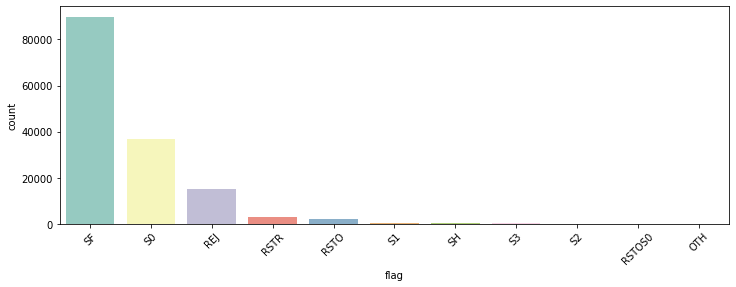

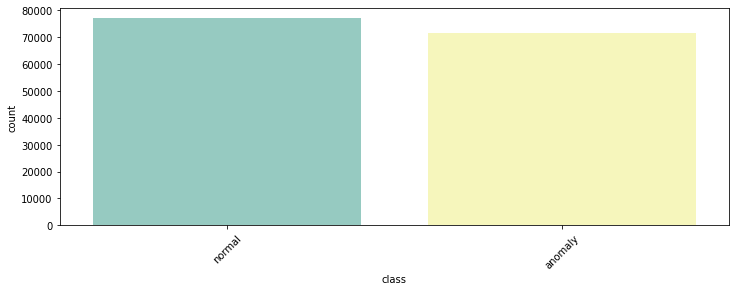

In [ ]:
# Looping through all the features by our y variable - see if there is relationship

features = ['protocol_type', 'service', 'flag', 'class']
for f in features:
    plt.figure(figsize=(12,4)) # this creates a figure 8 inch wide, 4 inch high

    sns.countplot(x = f, data = data, palette = 'Set3',order = data[f].value_counts().iloc[:20].index)
    plt.xticks(rotation=45)
    plt.show()
    

In [ ]:
'''
print(data.shape)
categoric = ['protocol_type', 'service', 'flag']
#Training dataset one hot encoding
ohe1 = OneHotEncoder(handle_unknown = 'ignore')
ohe1.fit(data[categoric])
array_hot_encoded1 = ohe1.transform(data[categoric]).toarray()
data_hot_encoded1 = pd.DataFrame(array_hot_encoded1, index=data.index)

newdata = pd.concat([data_hot_encoded1,data], axis=1)
newdata = newdata.drop(columns=categoric)
print(newdata.shape)
'''
print(data.shape)

categoric = ['protocol_type', 'service', 'flag']
# Making categorical variables into numeric representation by one- hot encoding
newdata = pd.get_dummies(data, columns = categoric)
newdata.drop(['class','id'], inplace=True, axis=1)
# print the shape
print(newdata.shape)



(148517, 43)
(148517, 122)


In [ ]:
newdata.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
newdata.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,...,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000
mean,276.779305,4.022795e+04,1.708885e+04,0.000215,0.020523,0.000202,0.189379,0.004323,0.402789,0.255062,0.001508,0.000976,0.273726,0.012073,0.000525,0.004013,0.0,0.000081,0.012308,83.336561,28.251937,0.256925,0.255337,0.137947,0.138487,0.672983,0.067761,0.097441,183.928042,119.462661,0.534521,0.084103,0.145932,0.030584,0.256122,0.251304,0.136220,0.136397,0.062848,0.818553,...,0.004525,0.002134,0.001199,0.034993,0.000141,0.000613,0.008639,0.000539,0.179286,0.000054,0.000619,0.000633,0.000545,0.055529,0.001771,0.002269,0.003636,0.003845,0.003427,0.026792,0.000027,0.000094,0.004646,0.000067,0.004208,0.005589,0.004949,0.004444,0.004935,0.000337,0.101557,0.015722,0.000707,0.020806,0.248214,0.002599,0.000956,0.002007,0.604779,0.002316
std,2460.683131,5.409612e+06,3.703525e+06,0.014677,0.240069,0.019417,2.013160,0.072248,0.490461,22.231375,0.038807,0.042389,22.689023,0.517863,0.027701,0.095257,0.0,0.008988,0.110259,116.760741,75.369635,0.431918,0.432578,0.339387,0.341783,0.436544,0.194666,0.258886,98.528328,111.232318,0.448061,0.194102,0.308638,0.108975,0.428500,0.429719,0.322741,0.335282,0.242690,0.385390,...,0.067114,0.046151,0.034599,0.183762,0.011890,0.024746,0.092543,0.023203,0.383593,0.007339,0.024881,0.025150,0.023347,0.229011,0.042044,0.047581,0.060189,0.061886,0.058442,0.161474,0.005190,0.009709,0.068003,0.008205,0.064735,0.074548,0.070175,0.066515,0.070079,0.018345,0.302066,0.124399,0.026580,0.142734,0.431978,0.050915,0.030907,0.044749,0.488900,0.048072
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
scaler =  MinMaxScaler()
X_value =pd.DataFrame(scaler.fit_transform(newdata))
print(X_value.mean())

print(X_value.std())

0      0.004796
1      0.000029
2      0.000013
3      0.000215
4      0.006841
         ...   
117    0.002599
118    0.000956
119    0.002007
120    0.604779
121    0.002316
Length: 122, dtype: float64
0      0.042635
1      0.003920
2      0.002827
3      0.014677
4      0.080023
         ...   
117    0.050915
118    0.030907
119    0.044749
120    0.488900
121    0.048072
Length: 122, dtype: float64


In [ ]:
X_value

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448141,0.019569,0.0,0.00,1.0,1.0,0.04,0.06,0.00,1.000000,0.039216,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266145,0.001957,0.0,0.00,1.0,1.0,0.01,0.06,0.00,1.000000,0.003922,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000035,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.00,0.0,0.0,1.00,0.00,0.00,0.525490,0.337255,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.127202,0.0,0.00,0.0,0.0,1.00,0.00,1.00,0.011765,0.223529,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000017,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.015656,0.0,0.12,1.0,0.5,1.00,0.00,0.75,0.113725,0.337255,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.048924,1.0,1.00,0.0,0.0,0.14,0.06,0.00,1.000000,0.098039,0.10,0.06,0.00,0.00,1.00,1.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
148513,0.000139,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.00,0.0,0.0,1.00,0.00,0.00,1.000000,0.956863,0.96,0.01,0.01,0.00,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
148514,0.000000,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.00,0.0,0.0,1.00,0.00,0.00,1.000000,0.117647,0.12,0.06,0.00,0.00,0.72,0.0,0.01,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
148515,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281800,0.015656,1.0,1.00,0.0,0.0,0.06,0.05,0.00,1.000000,0.031373,0.03,0.05,0.00,0.00,1.00,1.0,0.00,0.00,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# K-means Clustering

In [ ]:
# Running K means with multible Ks
best_seed = None
final_centroids = None
final_cluster_assignment = None

min_inertia = []
#X_value = newdata.values
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
  inertia = []
  no_of_clusters = range(2,15)
  print('\n\n seed= {} \n'.format(seed))
  for f in no_of_clusters:
      kmeans = KMeans(n_clusters=f, init='k-means++',random_state=seed)
      kmeans = kmeans.fit(X_value)
      
      u = kmeans.inertia_
      inertia.append(u)
      print("The innertia for :", f, "Clusters is:", u) 
      # if current measurement of heterogeneity is lower than previously seen,
      # update the minimum record of heterogeneity.
  if len(min_inertia) == 0 :
      min_inertia = inertia
      
  if min(inertia,default=0) < min(min_inertia,default=0):
      min_inertia = inertia
      best_seed = seed
      final_centroids = kmeans.cluster_centers_
      final_cluster_assignment = kmeans.labels_



 seed= 0 

The innertia for : 2 Clusters is: 16692435.946356097
The innertia for : 3 Clusters is: 15811662.822788663
The innertia for : 4 Clusters is: 15421735.320504138
The innertia for : 5 Clusters is: 15073682.386014774
The innertia for : 6 Clusters is: 14922127.51075582
The innertia for : 7 Clusters is: 14592525.509544581
The innertia for : 8 Clusters is: 14148091.415742602
The innertia for : 9 Clusters is: 14000288.100977395
The innertia for : 10 Clusters is: 13826035.630829653
The innertia for : 11 Clusters is: 13682899.736171948
The innertia for : 12 Clusters is: 13391504.553461455
The innertia for : 13 Clusters is: 13181269.448391806
The innertia for : 14 Clusters is: 13031862.997921972


 seed= 20000 

The innertia for : 2 Clusters is: 16692435.946356097
The innertia for : 3 Clusters is: 15811662.807950515
The innertia for : 4 Clusters is: 15421735.336218525
The innertia for : 5 Clusters is: 15140986.860798974
The innertia for : 6 Clusters is: 15000536.769872526
The innertia

In [ ]:
print(min_inertia)
print(best_seed)

[16692453.812132085, 16303243.495385861, 15318434.882686784, 14894378.03892841, 14720963.825236063, 14565657.432471309, 14242895.517647041, 14051174.966669068, 13691845.819860106, 13613292.287833039, 13407458.431760604, 13265618.904526766, 13005177.81735413]
100000


Text(0.5, 1.0, 'Inertia Plot per k for Best Seed 100000')

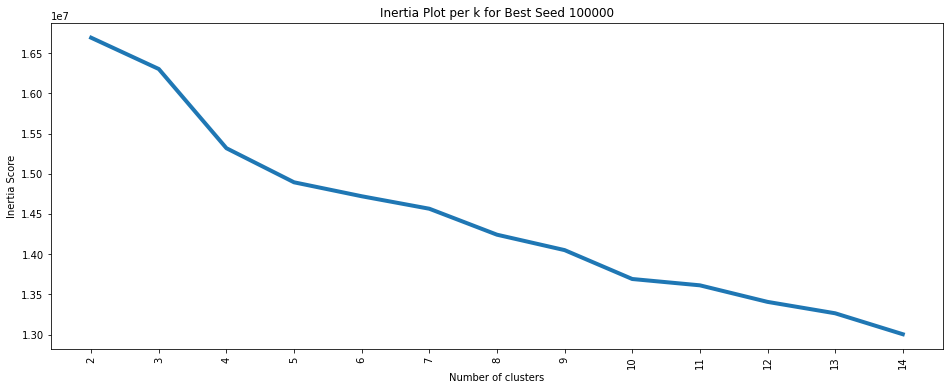

In [ ]:
# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, min_inertia,linewidth=4)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title('Inertia Plot per k for Best Seed {}'.format(best_seed))

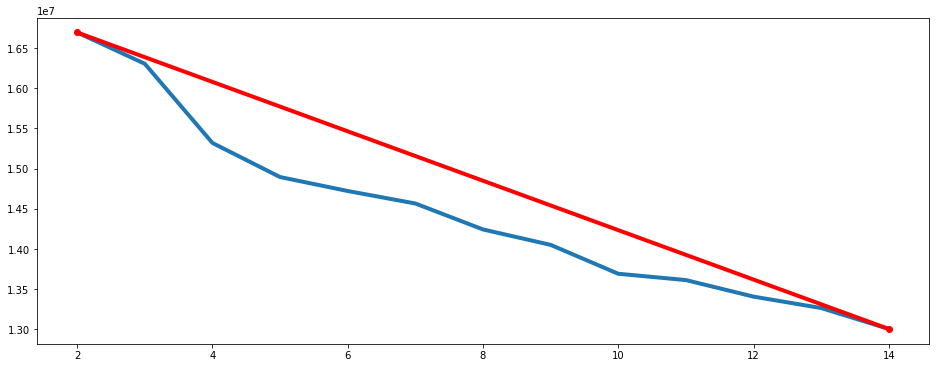

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, min_inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [min_inertia[0], 
                        min_inertia[-1]], 'ro-',linewidth=4)
plt.show()



In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

13

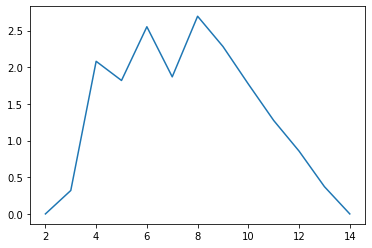

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

8

In [ ]:
# Running K means on K clusters

kmeans = KMeans(n_clusters=K,init='k-means++', random_state=best_seed)
kmeans = kmeans.fit(X_value)
kmeans.inertia_

predictions = kmeans.predict(X_value)




164128.99632720335

In [ ]:
# calculating the Counts of the cluster
#unique, counts = np.unique(kmeans.labels_, return_counts=True)

print(np.bincount(kmeans.labels_))


[43935 19849 23142  9923  7716 20537 14081  9334]


Explained variance ratio (first two components): [0.388883 0.171668]


<Figure size 432x288 with 0 Axes>

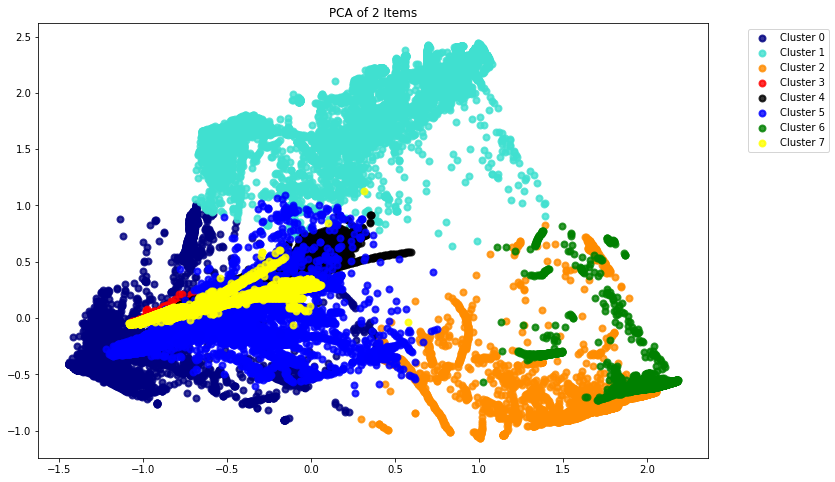

In [ ]:
# Running PCA to Visualize the data

X = X_value

y_num = predictions

pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X).transform(X)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','blue','green','yellow']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4,5,6,7], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

In [ ]:
# Trying with Dimentionality reduction and then Kmeans

n_components = X.shape[1]

# Running PCA with all components
pca = PCA(n_components=n_components, random_state = best_seed)
X_r = pca.fit(X).transform(X)


# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_98 = total_variance * 0.98
print("The 98% variance we want to have is: ", var_98)
print("")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
print("Variance explain with 30 n_compononets: ", sum(a["Explained Variance"][0:30]))
print("Variance explain with 35 n_compononets: ", sum(a["Explained Variance"][0:35]))
print("Variance explain with 40 n_compononets: ", sum(a["Explained Variance"][0:40]))
print("Variance explain with 41 n_compononets: ", sum(a["Explained Variance"][0:41]))
print("Variance explain with 50 n_compononets: ", sum(a["Explained Variance"][0:50]))
print("Variance explain with 53 n_compononets: ", sum(a["Explained Variance"][0:53]))
print("Variance explain with 55 n_compononets: ", sum(a["Explained Variance"][0:55]))
print("Variance explain with 60 n_compononets: ", sum(a["Explained Variance"][0:60]))


Total Variance in our dataset is:  4.230204086184797
The 98% variance we want to have is:  4.145600004461101

Variance explain with 30 n_compononets:  4.036399231346346
Variance explain with 35 n_compononets:  4.064565989464682
Variance explain with 40 n_compononets:  4.0894058837885225
Variance explain with 41 n_compononets:  4.094126236073808
Variance explain with 50 n_compononets:  4.132060736417562
Variance explain with 53 n_compononets:  4.1432658984419
Variance explain with 55 n_compononets:  4.150456065525136
Variance explain with 60 n_compononets:  4.167349111900273


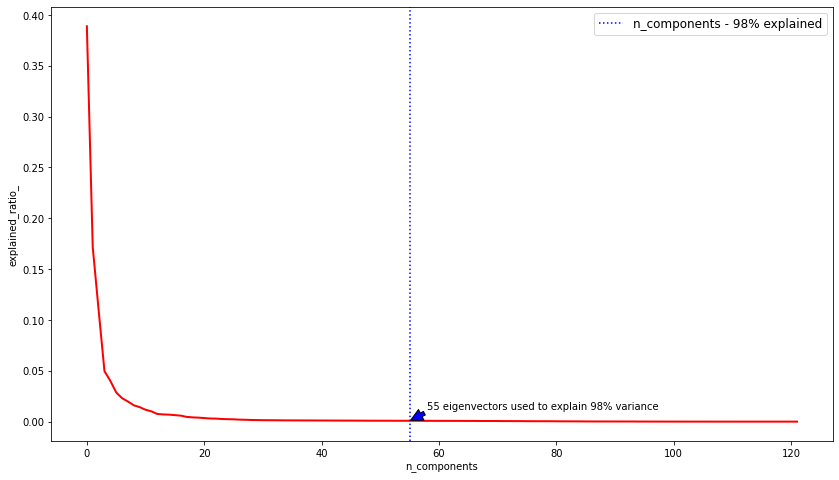

In [ ]:

# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c="r")
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 98% e.v.
plt.axvline(55,linestyle=':', label='n_components - 98% explained', c ="blue")
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate('55 eigenvectors used to explain 98% variance', xy=(55, pca.explained_variance_ratio_[55]), 
             xytext=(58, pca.explained_variance_ratio_[10]),
            arrowprops=dict(facecolor='blue', shrink=0.05))

plt.show()

The innertia for : 2 Clusters is: 401435.85671324586
The innertia for : 3 Clusters is: 287338.55002233706
The innertia for : 4 Clusters is: 221425.18146024636
The innertia for : 5 Clusters is: 193770.24425531825
The innertia for : 6 Clusters is: 172080.14794450646
The innertia for : 7 Clusters is: 161302.67233941978
The innertia for : 8 Clusters is: 151523.46218499576
The innertia for : 9 Clusters is: 142542.7638363328
The innertia for : 10 Clusters is: 133256.45505544162
The innertia for : 11 Clusters is: 124543.37377236242
The innertia for : 12 Clusters is: 117829.15930101107
The innertia for : 13 Clusters is: 111259.6432801774
The innertia for : 14 Clusters is: 106708.51344234518


Text(0.5, 1.0, 'Inertia Plot per k')

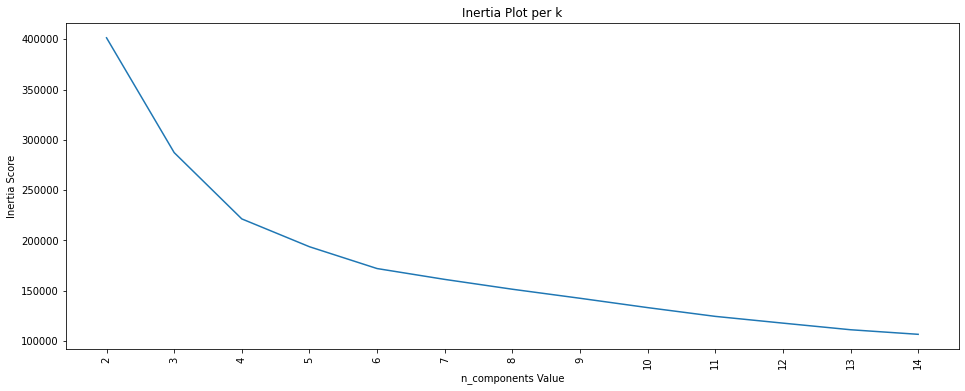

In [ ]:
# Running PCA again

pca = PCA(n_components=55, random_state = 453)
X_r = pca.fit(X).transform(X)

inertia = []

#running Kmeans

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=best_seed)
    kmeans = kmeans.fit(X_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)

# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

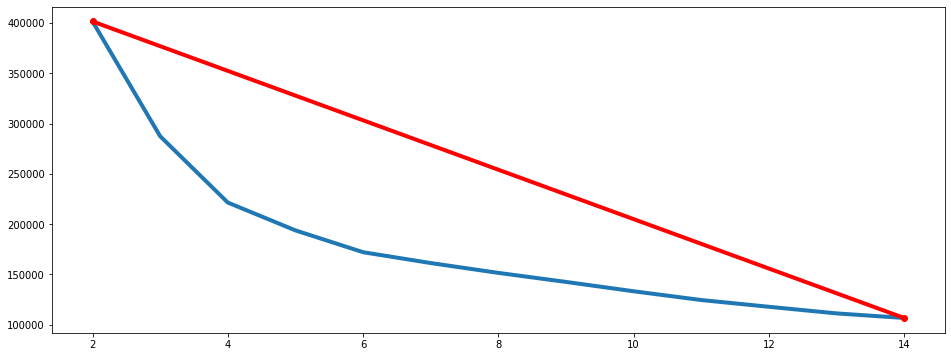

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(16,6))
plt.plot(no_of_clusters, inertia,linewidth=4)
plt.plot([no_of_clusters[0], no_of_clusters[-1]], [inertia[0], 
                        inertia[-1]], 'ro-',linewidth=4)
plt.show()


In [ ]:
# between-a-point-and-a-line-in-2-d/
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [ ]:
a = inertia[0] - inertia[-1]
b = no_of_clusters[-1] - no_of_clusters[0]
c1 = no_of_clusters[0] * inertia[-1]
c2 = no_of_clusters[-1] * inertia[0]
c = c1 - c2

In [ ]:
r = no_of_clusters[-1]-1
r

13

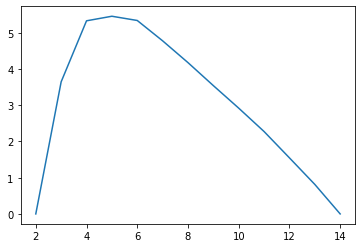

In [ ]:
distance_of_points_from_line = []

for k in range(int(r)):
  distance_of_points_from_line.append(
      calc_distance(no_of_clusters[k], inertia[k], a, b, c))
  
plt.plot(no_of_clusters, distance_of_points_from_line)

In [ ]:
K =no_of_clusters[distance_of_points_from_line.index(max(distance_of_points_from_line))]
print("Best K value : {}".format(K))

Best K value : 5


In [ ]:
# Running PCA with 36 PC

# Running Kmeans with 5 Ks
kmeans = KMeans(n_clusters=5, random_state=best_seed)
kmeans = kmeans.fit(X_r)

print("Optimized K-mean innertia for cluster 5 :", kmeans.inertia_)

Optimized K-mean innertia for cluster 5 : 205656.67052409434


Explained variance ratio (PCA 2 components): 0.5713646026278789


<Figure size 432x288 with 0 Axes>

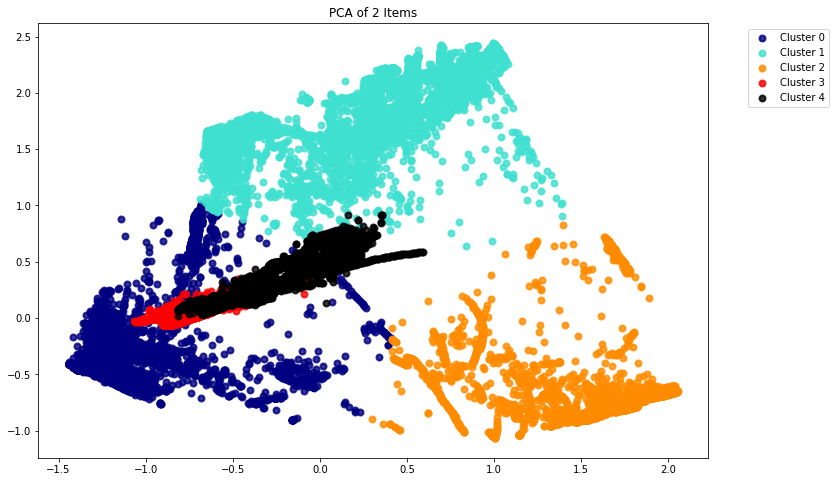

In [ ]:
# Running PCA to Visualize the data


pca = PCA(n_components=2, random_state = 453)
X_r = pca.fit(X_r).transform(X_r)

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

# Percentage of variance explained for each components
print('Explained variance ratio (PCA 2 components): %s' % str(sum(pca.explained_variance_ratio_)))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()